<a href="https://colab.research.google.com/github/kamadomin/PyTorchLearning/blob/main/Simple_nn_correct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If needed:
# !pip install pandas scikit-learn torch matplotlib

import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt


In [2]:
#1) Reproducibility (fix all seeds)
def set_all_seeds(seed=32):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # If you ever use CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(32)


In [3]:
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
my_df = pd.read_csv(url)

# Rename columns to shorter names (optional)
my_df.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]

# Encode species -> int labels (required for CrossEntropyLoss)
label_map = {"setosa": 0, "versicolor": 1, "virginica": 2}
my_df["label"] = my_df["species"].map(label_map).astype(int)

# Features & labels
X_np = my_df[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values.astype(np.float32)
y_np = my_df["label"].values.astype(np.int64)   # <- int64 for CrossEntropyLoss


In [4]:
# 60% train, 20% val, 20% test (stratify preserves class balance)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_np, y_np, test_size=0.4, random_state=42, stratify=y_np
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (90, 4) Val: (30, 4) Test: (30, 4)


In [5]:
#Standardize (fit on train only!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


In [6]:
#Convert to PyTorch tensors + DataLoaders
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t   = torch.from_numpy(X_val)
y_val_t   = torch.from_numpy(y_val)
X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False)


In [8]:
#Define a simple model
class IrisNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 3)   # 3 classes → logits (no softmax here)
        )
    def forward(self, x):
        return self.net(x)

model = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [9]:
#Training loop with validation & best checkpoint
epochs = 100
train_losses = []
val_losses = []

best_val_loss = float("inf")
best_state = None

for epoch in range(epochs):
    # ---- Train ----
    model.train()
    running_train_loss = 0.0

    for xb, yb in train_dl:
        logits = model(xb)                 # ✅ call model(x), not .forward()
        loss = criterion(logits, yb)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_ds)
    train_losses.append(epoch_train_loss)

    # ---- Validate ----
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            logits = model(xb)
            loss = criterion(logits, yb)
            running_val_loss += loss.item() * xb.size(0)

    epoch_val_loss = running_val_loss / len(val_ds)
    val_losses.append(epoch_val_loss)

    # Save best (by val loss)
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | train_loss={epoch_train_loss:.4f} | val_loss={epoch_val_loss:.4f}")

# Load best validation weights before final test
if best_state is not None:
    model.load_state_dict(best_state)


Epoch   0 | train_loss=0.9570 | val_loss=0.7989
Epoch  10 | train_loss=0.0687 | val_loss=0.0753
Epoch  20 | train_loss=0.0326 | val_loss=0.0664
Epoch  30 | train_loss=0.0377 | val_loss=0.0597
Epoch  40 | train_loss=0.0146 | val_loss=0.0538
Epoch  50 | train_loss=0.0141 | val_loss=0.0710
Epoch  60 | train_loss=0.0084 | val_loss=0.0607
Epoch  70 | train_loss=0.0034 | val_loss=0.0667
Epoch  80 | train_loss=0.0030 | val_loss=0.1022
Epoch  90 | train_loss=0.0021 | val_loss=0.0958


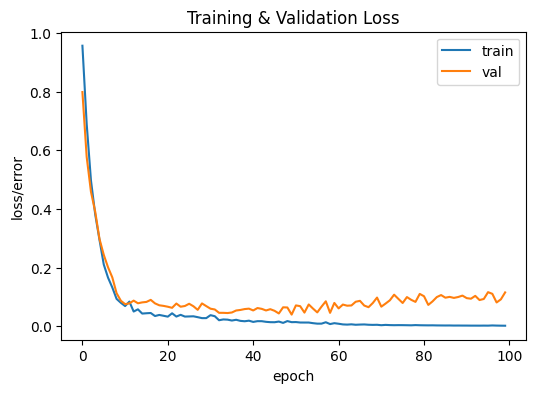

In [10]:
plt.figure(figsize=(6,4))
plt.plot(range(epochs), train_losses, label="train")
plt.plot(range(epochs), val_losses,   label="val")
plt.xlabel("epoch")
plt.ylabel("loss/error")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


In [11]:
model.eval()
test_loss = 0.0
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        loss = criterion(logits, yb)
        test_loss += loss.item() * xb.size(0)

        preds = logits.argmax(dim=1)
        all_preds.append(preds.numpy())
        all_targets.append(yb.numpy())

test_loss /= len(test_ds)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

correct = int((all_preds == all_targets).sum())
total = len(all_targets)
acc = correct / total

print(f"Test loss: {test_loss:.4f}")
print(f"Correct: {correct}/{total}  (accuracy = {acc*100:.2f}%)")

# Confusion matrix + report
cm = confusion_matrix(all_targets, all_preds, labels=[0,1,2])
print("\nConfusion matrix (rows=true, cols=pred):\n", cm)

target_names = ["setosa (0)", "versicolor (1)", "virginica (2)"]
print("\nClassification report:\n",
      classification_report(all_targets, all_preds, target_names=target_names, digits=4))


Test loss: 0.2950
Correct: 27/30  (accuracy = 90.00%)

Confusion matrix (rows=true, cols=pred):
 [[10  0  0]
 [ 0 10  0]
 [ 0  3  7]]

Classification report:
                 precision    recall  f1-score   support

    setosa (0)     1.0000    1.0000    1.0000        10
versicolor (1)     0.7692    1.0000    0.8696        10
 virginica (2)     1.0000    0.7000    0.8235        10

      accuracy                         0.9000        30
     macro avg     0.9231    0.9000    0.8977        30
  weighted avg     0.9231    0.9000    0.8977        30



In [12]:
#Predict on a new sample (and get label)
# Example: take the first test sample
x_example = X_test[:1]                     # shape (1,4) in numpy
x_example_t = torch.from_numpy(x_example)  # to tensor

with torch.no_grad():
    logits = model(x_example_t[0])         # single sample → shape (3,)
    probs = torch.softmax(logits, dim=0)
    pred_idx = int(torch.argmax(logits).item())

idx_to_name = {0: "setosa", 1: "versicolor", 2: "virginica"}
print("Logits:", logits.numpy())
print("Probs:", probs.numpy())
print("Predicted label index:", pred_idx, "→", idx_to_name[pred_idx])


Logits: [-2.766828  4.85887  -4.273179]
Probs: [4.8746413e-04 9.9940443e-01 1.0807930e-04]
Predicted label index: 1 → versicolor


1. Imports

We load pandas, numpy, torch, sklearn, and matplotlib → these cover data handling, model building, evaluation, and plotting.

2. Reproducibility

We fix random seeds (np, torch, etc.) so results are repeatable (otherwise training will vary).

3. Load the dataset

CSV → pandas.DataFrame

Replace species names (setosa, versicolor, virginica) with numeric labels (0, 1, 2).
Why? Because PyTorch’s CrossEntropyLoss requires integer labels.

4. Split the data

Divide into train (60%), validation (20%), test (20%).

Use stratify=y so each set has balanced class proportions.
Why? Train = learn, Val = tune hyperparameters/check overfitting, Test = final unbiased check.

5. Normalize features

Standardize each feature (mean 0, std 1) using StandardScaler.

Fit on training set only, then transform val/test.
Why? Neural networks converge faster and more stably when features are normalized.

6. Convert to PyTorch tensors & DataLoaders

Convert numpy arrays → torch.tensor.

Wrap in TensorDataset and DataLoader for batching & shuffling.
Why? PyTorch training loops work best with DataLoaders.

7. Define the model

nn.Sequential with Linear → ReLU → Linear → ReLU → Linear(3).

Output layer has 3 neurons (one per class).
Why? Each neuron corresponds to a class score (logit).

8. Loss function & optimizer

CrossEntropyLoss: combines Softmax + NLLLoss. Perfect for multi-class classification.

Adam optimizer: adaptive gradient method, faster convergence.

9. Training loop

For each epoch:

Forward pass → predictions from model.

Compute loss vs. true labels.

Backward pass → compute gradients.

Optimizer step → update weights.

Track training loss.
Then run on validation set to monitor generalization.

We also save the best model (lowest val loss).

10. Plot loss curves

Show training vs. validation loss across epochs.

Helps visualize overfitting (train ↓ while val ↑).

11. Test evaluation

After training, load the best model.

Run on the test set → compute:

Loss

Accuracy (# correct / total)

Confusion matrix (see misclassifications)

Classification report (precision, recall, f1)

12. Single prediction

Take one flower’s features.

Run model(x) → logits.

Apply Softmax for probabilities.

Use argmax for predicted class.

Map index back to label (0=setosa, 1=versicolor, 2=virginica).

✅ In short:

Load + preprocess → split → scale → tensor.

Define NN model → choose loss/optimizer.

Train with backprop + track val loss.

Plot training curve.

Evaluate on test (report accuracy, confusion matrix).

Use Softmax + argmax for predictions.

##Claude
What's Done Correctly

No softmax in the model - The model outputs raw logits, exactly as it should when using CrossEntropyLoss:

python   nn.Linear(16, 3)   # logits (no softmax)

Proper use of CrossEntropyLoss - It expects logits, not probabilities
Softmax only at inference - Applied correctly when getting probabilities for the example prediction:

python   probs = torch.softmax(logits, dim=1)

Good practices:

Reproducibility with seed setting
Proper train/val/test split (60/20/20)
Feature scaling with StandardScaler
Model set to .train() and .eval() modes appropriately
Early stopping logic (saves best validation weights)
optimizer.zero_grad(set_to_none=True) for efficiency
Proper use of torch.no_grad() during evaluation


Clean evaluation - Uses argmax to get predictions from logits (no need for softmax since we only care about the highest value)

Minor Suggestions (optional improvements)

You could add device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') for GPU support
The space in the URL (url ='https://...) could be url = 'https://...' for consistency

But overall, this is excellent code that demonstrates the correct PyTorch classification pattern! 🎯RetryClaude can make mistakes. Please double-check responses. Sonnet 4.5